In [1]:
import matplotlib.font_manager
matplotlib.font_manager._rebuild()

In [3]:
fm = matplotlib.font_manager.json_load("C:\\Users\\Martin\\.matplotlib\\fontlist-v330.json")
print(fm.findfont("serif", rebuild_if_missing=False))
fm.findfont("serif", fontext="afm", rebuild_if_missing=False)

C:\Users\Martin\anaconda3\envs\bakalarka\Lib\site-packages\matplotlib\mpl-data\fonts\ttf\DejaVuSerif.ttf


'C:\\Users\\Martin\\anaconda3\\envs\\bakalarka\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\afm\\pncr8a.afm'

In [4]:
from matplotlib import rc
rc('text', usetex=True)
rc('font', **{'family': 'serif', 'serif': ['Times-Roman']})

In [5]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
import random
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F

from classes.cube_classes import Cube3State, Cube3
from generate.generate_states import ids_to_color
from utils.random_seed import seed_worker, seed_all, init_weights

torch.set_default_dtype(torch.float64)

import seaborn as sns
import matplotlib.pyplot as plt
import os

In [3]:
for subdir, dirs, files in os.walk('results/'):
    print(subdir)
    for file in files:
        if '00000000' in file:
            filepath = os.path.join(subdir, file)
            first_part, second_part = file.split('_ts')
            first_part += '_ts'
            n1, n2, last_part = second_part.split('.')
            number = round(float(n1 + '.' + n2), 1)
            os.rename(filepath, os.path.join(subdir, first_part + f'{number:0.1f}' + '.' + last_part))

results/
results/.ipynb_checkpoints
results/2moves
results/2moves\FeedForward
results/2moves\ResNet
results/2moves\SymEqNet
results/3moves
results/3moves\FeedForward
results/3moves\ResNet
results/3moves\SymEqNet
results/4moves
results/4moves\FeedForward
results/4moves\ResNet
results/4moves\SymEqNet
results/5moves
results/5moves\FeedForward
results/5moves\old
results/5moves\old\ResNet
results/5moves\old\SymEqNet
results/5moves\ResNet
results/5moves\SymEqNet
results/6moves
results/6moves\FeedForward
results/6moves\ResNet
results/6moves\SymEqNet
results/6moves\SymEqNet_1000_1000
results/6moves\SymEqNet_GATv2
results/6moves\SymEqNet_Generalized
results/6moves\SymEqNet_PNA
results/6moves\SymEqNet_zaloha
results/kociemba
results/kociemba\FeedForward_adv
results/kociemba\ResNet
results/kociemba\ResNet_adv
results/kociemba\SymEqNet
results/kociemba10
results/kociemba10\ResNet_adv
results/kociemba10\SymEqNet_adv
results/kociemba100
results/kociemba100\ResNet_adv
results/kociemba100\SymEqNet_adv

# Testsize Experiments

In [62]:
DATASET = '5moves'
# models = ['SymEqNet_100_500', 'SymEqNet_1000_1000', 'ResNet']
# models = ['SymEqNet_1000_1000', 'ResNet']
# models = ['SymEqNet', 'SymEqNet_PNA', 'SymEqNet_Generalized', 'SymEqNet_GATv2', 'ResNet', 'FeedForward']
models = ['SymEqNet', 'ResNet']

In [63]:
RESULT_FOLDERS = {
    model: f'results/{DATASET}/{model}' for model in models
}

In [64]:
test_sizes = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
configs = [(rnd_seed, test_size) for rnd_seed in range(0, 10) for test_size in test_sizes]

In [65]:
last_train_losses_dict, last_test_losses_dict, mean_train_losses_dict, mean_test_losses_dict, results_train_dict, results_test_dict = \
    {model: {test_size: [] for test_size in test_sizes} for model in models}, {model: {test_size: [] for test_size in test_sizes} for model in models}, {model: {test_size: [] for test_size in test_sizes} for model in models}, {model: {test_size: [] for test_size in test_sizes} for model in models}, {model: {test_size: [] for test_size in test_sizes} for model in models}, {model: {test_size: [] for test_size in test_sizes} for model in models}

for model in models:
    for i, config in enumerate(configs):
        if os.path.isfile(RESULT_FOLDERS[model] + f'/last_train_losses_rs{config[0]}_ts{config[1]:0.1f}.npy'):
            last_train_losses = np.load(RESULT_FOLDERS[model] + f'/last_train_losses_rs{config[0]}_ts{config[1]:0.1f}.npy')
            last_test_losses = np.load(RESULT_FOLDERS[model] + f'/last_test_losses_rs{config[0]}_ts{config[1]:0.1f}.npy')
            mean_train_losses = np.load(RESULT_FOLDERS[model] + f'/mean_train_losses_rs{config[0]}_ts{config[1]:0.1f}.npy')
            mean_test_losses = np.load(RESULT_FOLDERS[model] + f'/mean_test_losses_rs{config[0]}_ts{config[1]:0.1f}.npy')
            results = np.load(RESULT_FOLDERS[model] + f'/results_rs{config[0]}_ts{config[1]:0.1f}.npy')
        else:
            last_train_losses = []
            last_test_losses = []
            mean_train_losses = np.zeros(1000)
            mean_test_losses = np.zeros(1000)
            results = [0, 0]

        last_train_losses_dict[model][config[1]].append(last_train_losses)
        last_test_losses_dict[model][config[1]].append(last_test_losses)
        mean_train_losses_dict[model][config[1]].append(mean_train_losses)
        mean_test_losses_dict[model][config[1]].append(mean_test_losses)
        results_train_dict[model][config[1]].append(results[0])
        results_test_dict[model][config[1]].append(results[1])

In [66]:
models_maes_stds = []
for model in models:
    maes_stds= []
    print(f'MODEL {model}')
    for key in results_test_dict[model]:
        mean = np.mean(results_test_dict[model][key])
        std = np.std(results_test_dict[model][key])
        print(f'Test Size {int(key*100)}%: MAE {mean:.4f} +- {std:.4f}')
        maes_stds.append(f'{mean:.4f} +- {std:.4f}')
    print('')
    models_maes_stds.append(maes_stds)
df_res = pd.DataFrame({'test_size': test_sizes, models[1]: models_maes_stds[1], models[0]: models_maes_stds[0]}).set_index('test_size')
df_res.to_csv(f'result_df_{DATASET}.csv')

MODEL SymEqNet
Test Size 10%: MAE 0.0778 +- 0.0694
Test Size 20%: MAE 0.1013 +- 0.0555
Test Size 30%: MAE 0.0533 +- 0.0203
Test Size 40%: MAE 0.0914 +- 0.0421
Test Size 50%: MAE 0.0864 +- 0.0347
Test Size 60%: MAE 0.1207 +- 0.0396
Test Size 70%: MAE 0.0919 +- 0.0284
Test Size 80%: MAE 0.1036 +- 0.0267
Test Size 90%: MAE 0.1351 +- 0.0189

MODEL ResNet
Test Size 10%: MAE 0.0612 +- 0.0119
Test Size 20%: MAE 0.0680 +- 0.0098
Test Size 30%: MAE 0.0894 +- 0.0148
Test Size 40%: MAE 0.1030 +- 0.0072
Test Size 50%: MAE 0.1208 +- 0.0080
Test Size 60%: MAE 0.1322 +- 0.0086
Test Size 70%: MAE 0.1744 +- 0.0098
Test Size 80%: MAE 0.2096 +- 0.0089
Test Size 90%: MAE 0.2617 +- 0.0044



In [67]:
model_ls, random_seed_ls, test_size_ls, train_loss_ls, test_loss_ls, epochs = [], [], [], [], [], []
# for model in ['SymEqNet', 'ResNet']:
for model in models:
    for rs, ts in configs:
        for epoch in range(100):
            model_ls.append(model)
            random_seed_ls.append(rs)
            test_size_ls.append(ts)
            train_loss_ls.append(mean_train_losses_dict[model][ts][rs][epoch])
            test_loss_ls.append(mean_test_losses_dict[model][ts][rs][epoch])
            epochs.append(epoch+1)

In [68]:
model_label_dict = {'SymEqNet': 'SymmetryNet', 'ResNet': 'DeepCube', 'SymEqNet_adv': 'SymmetryNet', 'ResNet_adv': 'DeepCube'}

In [69]:
df = pd.DataFrame({'Model': list(map(lambda x: model_label_dict[x], model_ls)), 'random_seed': random_seed_ls, 'test_size': test_size_ls, 'train_loss': train_loss_ls, 'test_loss': test_loss_ls, 'epoch': epochs})
print(df[['random_seed', 'train_loss']].groupby('random_seed').last())
df.head()

             train_loss
random_seed            
0              0.047059
1              0.047969
2              0.045684
3              0.053360
4              0.042559
5              0.040766
6              0.043481
7              0.043841
8              0.053173
9              0.045439


,Model,random_seed,test_size,train_loss,test_loss,epoch
0,SymmetryNet,0,0.1,9.112621,9.114051,1
1,SymmetryNet,0,0.1,0.810000,0.211911,2
2,SymmetryNet,0,0.1,0.202402,0.225558,3
3,SymmetryNet,0,0.1,0.182497,0.165893,4
4,SymmetryNet,0,0.1,0.172430,0.177601,5


In [70]:
os.makedirs(f'imgs/convergence/{DATASET}', exist_ok=True)

,Model,random_seed,test_size,train_loss,test_loss,epoch
0,SymmetryNet,0,0.1,9.112621,9.114051,1
1,SymmetryNet,0,0.1,0.810000,0.211911,2
2,SymmetryNet,0,0.1,0.202402,0.225558,3
3,SymmetryNet,0,0.1,0.182497,0.165893,4
4,SymmetryNet,0,0.1,0.172430,0.177601,5


2000


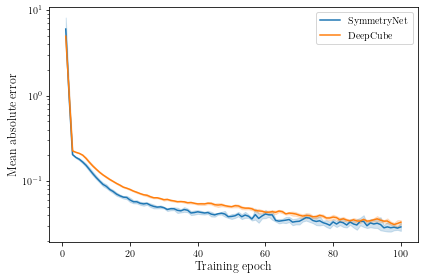

,Model,random_seed,test_size,train_loss,test_loss,epoch
100,SymmetryNet,0,0.2,9.112226,9.114914,1
101,SymmetryNet,0,0.2,0.875036,0.229974,2
102,SymmetryNet,0,0.2,0.204969,0.189557,3
103,SymmetryNet,0,0.2,0.195166,0.177839,4
104,SymmetryNet,0,0.2,0.185604,0.195446,5


2000


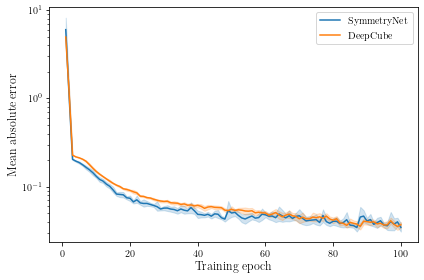

,Model,random_seed,test_size,train_loss,test_loss,epoch
200,SymmetryNet,0,0.3,9.112180,9.114125,1
201,SymmetryNet,0,0.3,0.975753,0.261069,2
202,SymmetryNet,0,0.3,0.201258,0.203437,3
203,SymmetryNet,0,0.3,0.192652,0.180261,4
204,SymmetryNet,0,0.3,0.182567,0.197091,5


2000


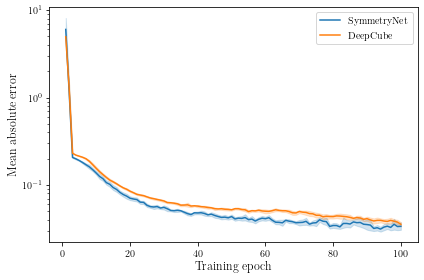

,Model,random_seed,test_size,train_loss,test_loss,epoch
300,SymmetryNet,0,0.4,9.111393,9.114820,1
301,SymmetryNet,0,0.4,1.109575,0.249593,2
302,SymmetryNet,0,0.4,0.211956,0.210304,3
303,SymmetryNet,0,0.4,0.203388,0.200136,4
304,SymmetryNet,0,0.4,0.185869,0.184526,5


2000


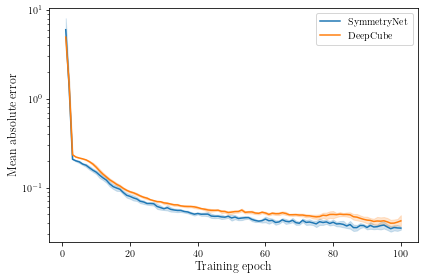

,Model,random_seed,test_size,train_loss,test_loss,epoch
400,SymmetryNet,0,0.5,9.111593,9.113934,1
401,SymmetryNet,0,0.5,1.292868,0.206576,2
402,SymmetryNet,0,0.5,0.215197,0.232669,3
403,SymmetryNet,0,0.5,0.203926,0.241043,4
404,SymmetryNet,0,0.5,0.201216,0.229876,5


2000


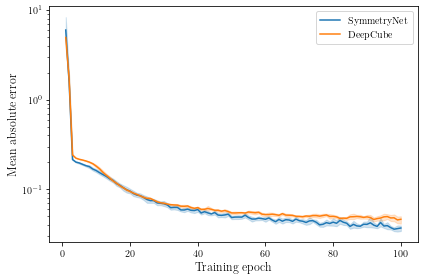

,Model,random_seed,test_size,train_loss,test_loss,epoch
500,SymmetryNet,0,0.6,9.112584,9.112883,1
501,SymmetryNet,0,0.6,1.544663,0.271538,2
502,SymmetryNet,0,0.6,0.249541,0.236816,3
503,SymmetryNet,0,0.6,0.201253,0.229302,4
504,SymmetryNet,0,0.6,0.190585,0.202546,5


2000


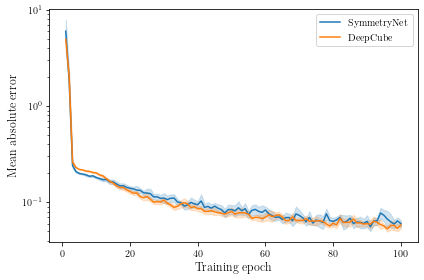

,Model,random_seed,test_size,train_loss,test_loss,epoch
600,SymmetryNet,0,0.7,9.112016,9.113084,1
601,SymmetryNet,0,0.7,1.971307,0.767603,2
602,SymmetryNet,0,0.7,0.240475,0.231754,3
603,SymmetryNet,0,0.7,0.211457,0.210262,4
604,SymmetryNet,0,0.7,0.197985,0.192611,5


2000


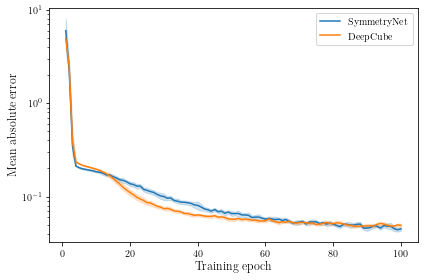

,Model,random_seed,test_size,train_loss,test_loss,epoch
700,SymmetryNet,0,0.8,9.111809,9.113002,1
701,SymmetryNet,0,0.8,2.596305,1.131067,2
702,SymmetryNet,0,0.8,0.451383,0.262278,3
703,SymmetryNet,0,0.8,0.229488,0.230024,4
704,SymmetryNet,0,0.8,0.226051,0.196253,5


2000


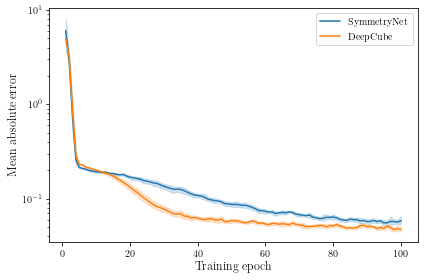

,Model,random_seed,test_size,train_loss,test_loss,epoch
800,SymmetryNet,0,0.9,9.111500,9.112904,1
801,SymmetryNet,0,0.9,3.476576,1.140575,2
802,SymmetryNet,0,0.9,1.601790,1.123499,3
803,SymmetryNet,0,0.9,0.587006,0.560062,4
804,SymmetryNet,0,0.9,0.243941,0.244802,5


2000


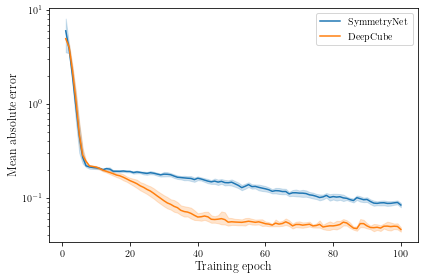

<Figure size 432x288 with 0 Axes>

In [71]:
for test_size in test_sizes:
    df_test_size = df[(df['test_size'] == test_size)] # & (df['epoch'] % 10 == 0)]
    display(df_test_size.head())
    print(len(df_test_size.index))
    sns.lineplot(data=df_test_size, x="epoch", y="train_loss", hue="Model")
#     plt.title(f'Convergence of MAE on train set, 10 random seeds, test size {test_size:0.1f}', fontsize=14)
    plt.title('')
    plt.yscale('log')
    plt.xlabel('Training epoch', fontsize=12)
    plt.ylabel('Mean absolute error', fontsize=12)
    plt.legend(title='')
    plt.tight_layout()
    plt.savefig(f'imgs/convergence/{DATASET}/train/train_conv_testsize_{test_size:0.1f}.png', dpi=100)
    plt.savefig(f'imgs/convergence/{DATASET}/train/train_conv_testsize_{test_size:0.1f}.pdf', format='pdf')
    plt.show()
    plt.cla()
    plt.clf()

Model           DeepCube
random_seed            9
test_size            0.1
train_loss     0.0342639
test_loss      0.0782102
epoch                100
Name: 17199, dtype: object


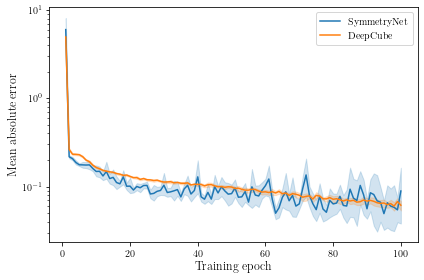

Model           DeepCube
random_seed            9
test_size            0.2
train_loss      0.044528
test_loss      0.0737521
epoch                100
Name: 17299, dtype: object


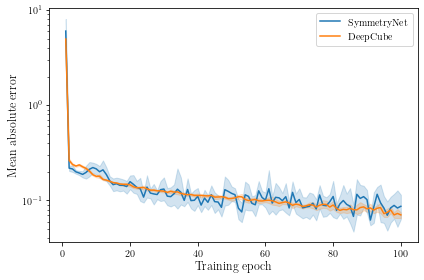

Model           DeepCube
random_seed            9
test_size            0.3
train_loss     0.0358721
test_loss      0.0895851
epoch                100
Name: 17399, dtype: object


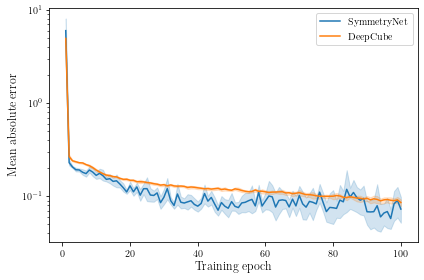

Model           DeepCube
random_seed            9
test_size            0.4
train_loss     0.0634944
test_loss       0.115203
epoch                100
Name: 17499, dtype: object


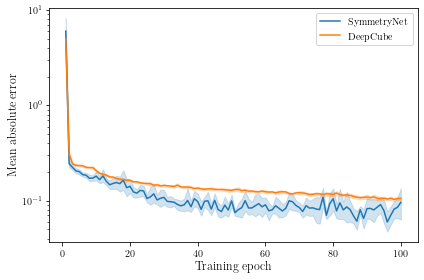

Model           DeepCube
random_seed            9
test_size            0.5
train_loss     0.0521694
test_loss       0.128513
epoch                100
Name: 17599, dtype: object


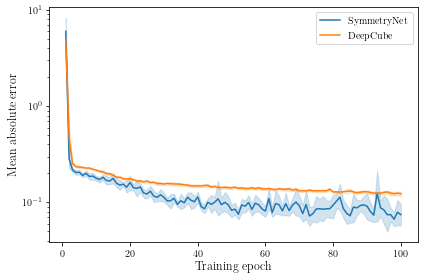

Model           DeepCube
random_seed            9
test_size            0.6
train_loss     0.0564147
test_loss        0.13983
epoch                100
Name: 17699, dtype: object


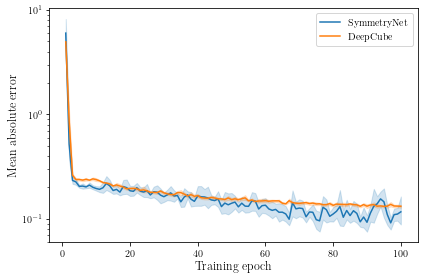

Model           DeepCube
random_seed            9
test_size            0.7
train_loss     0.0455645
test_loss       0.169885
epoch                100
Name: 17799, dtype: object


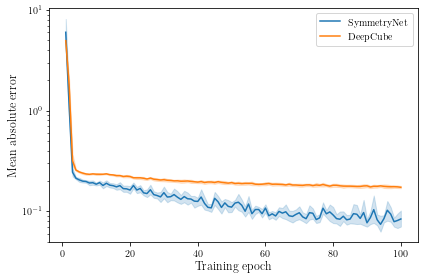

Model           DeepCube
random_seed            9
test_size            0.8
train_loss     0.0420827
test_loss       0.189122
epoch                100
Name: 17899, dtype: object


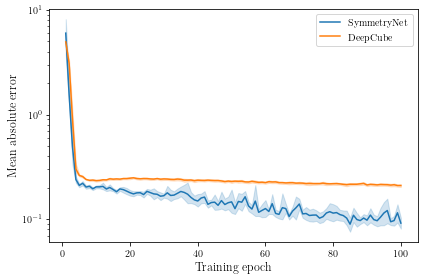

Model           DeepCube
random_seed            9
test_size            0.9
train_loss     0.0454386
test_loss       0.260497
epoch                100
Name: 17999, dtype: object


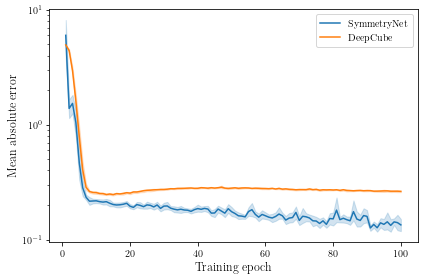

<Figure size 432x288 with 0 Axes>

In [72]:
for test_size in test_sizes:
    df_test_size = df[(df['test_size'] == test_size)]  # & (df['epoch'] % 10 == 0)]
    print(df_test_size.iloc[-1])
    sns.lineplot(data=df_test_size, x="epoch", y="test_loss", hue="Model")
#     plt.title(f'Convergence of MAE on test set, 10 random seeds, test size {test_size:0.1f}', fontsize=14)
    plt.title('')
    plt.yscale('log')
    plt.xlabel('Training epoch', fontsize=12)
    plt.ylabel('Mean absolute error', fontsize=12)
    plt.legend(title='')
    plt.tight_layout()
    plt.savefig(f'imgs/convergence/{DATASET}/test/test_conv_testsize_{test_size:0.1f}.png', dpi=100)
    plt.savefig(f'imgs/convergence/{DATASET}/test/test_conv_testsize_{test_size:0.1f}.pdf', format='pdf')
    plt.show()
    plt.cla()
    plt.clf()

Model           DeepCube
random_seed            9
test_size            0.1
train_loss     0.0342639
test_loss      0.0782102
epoch                100
Name: 17199, dtype: object


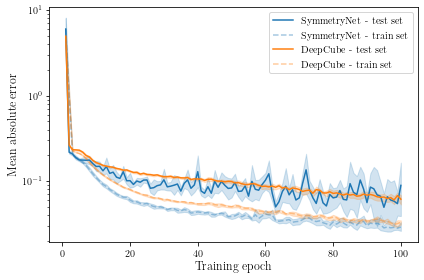

Model           DeepCube
random_seed            9
test_size            0.2
train_loss      0.044528
test_loss      0.0737521
epoch                100
Name: 17299, dtype: object


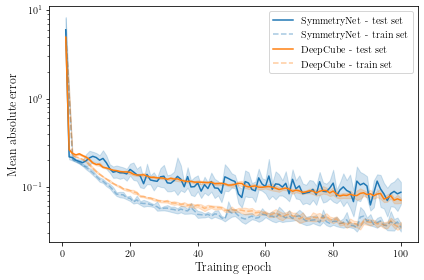

Model           DeepCube
random_seed            9
test_size            0.3
train_loss     0.0358721
test_loss      0.0895851
epoch                100
Name: 17399, dtype: object


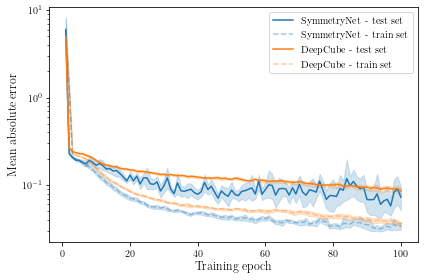

Model           DeepCube
random_seed            9
test_size            0.4
train_loss     0.0634944
test_loss       0.115203
epoch                100
Name: 17499, dtype: object


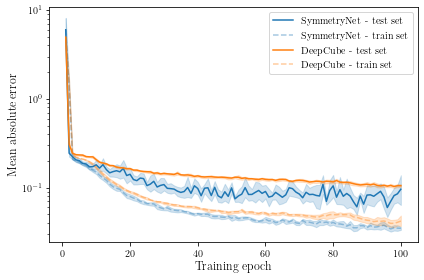

Model           DeepCube
random_seed            9
test_size            0.5
train_loss     0.0521694
test_loss       0.128513
epoch                100
Name: 17599, dtype: object


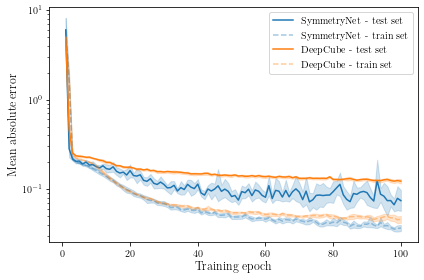

Model           DeepCube
random_seed            9
test_size            0.6
train_loss     0.0564147
test_loss        0.13983
epoch                100
Name: 17699, dtype: object


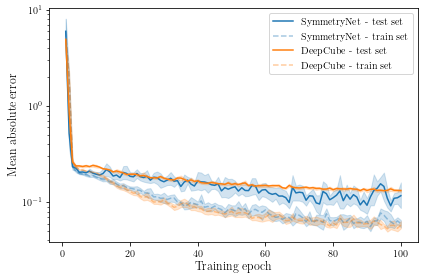

Model           DeepCube
random_seed            9
test_size            0.7
train_loss     0.0455645
test_loss       0.169885
epoch                100
Name: 17799, dtype: object


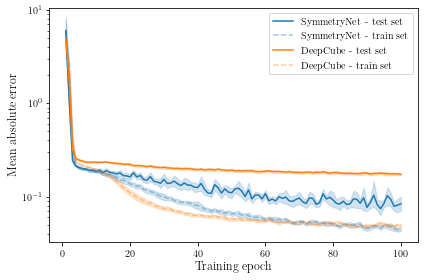

Model           DeepCube
random_seed            9
test_size            0.8
train_loss     0.0420827
test_loss       0.189122
epoch                100
Name: 17899, dtype: object


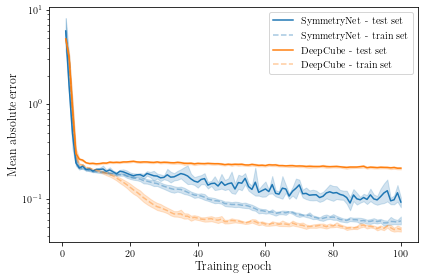

Model           DeepCube
random_seed            9
test_size            0.9
train_loss     0.0454386
test_loss       0.260497
epoch                100
Name: 17999, dtype: object


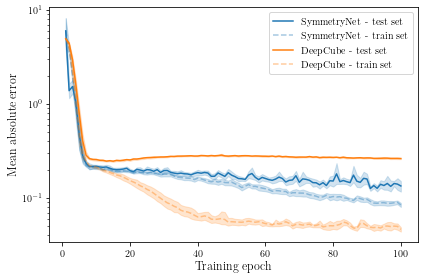

<Figure size 432x288 with 0 Axes>

In [73]:
# colors = ['blue', 'orange']
colors = sns.color_palette()[:len(models)]
for test_size in test_sizes:
    df_test_size = df[(df['test_size'] == test_size)] # & (df['epoch'] % 10 == 0)]
    print(df_test_size.iloc[-1])
    for q, model in enumerate(models):
        sns.lineplot(data=df_test_size[df_test_size['Model'] == model_label_dict[model]], x="epoch", y="test_loss", 
                     label=f"{model_label_dict[model]} - test set", color=colors[q])
        sns.lineplot(data=df_test_size[df_test_size['Model'] == model_label_dict[model]], x="epoch", y="train_loss", 
                     label=f"{model_label_dict[model]} - train set", linestyle='--', color=colors[q], alpha=0.4)
#     plt.title(f'Convergence of MAE, 10 random seeds, test size {test_size:0.1f}', fontsize=14)
    plt.title('')
    plt.yscale('log')
    plt.xlabel('Training epoch', fontsize=12)
    plt.ylabel('Mean absolute error', fontsize=12)
    plt.legend(title='')
    plt.tight_layout()
    plt.savefig(f'imgs/convergence/{DATASET}/train_test_combined/train_test_conv_testsize_{test_size:0.1f}.png', dpi=100)
    plt.savefig(f'imgs/convergence/{DATASET}/train_test_combined/train_test_conv_testsize_{test_size:0.1f}.pdf', format='pdf')
    plt.show()
    plt.cla()
    plt.clf()

In [74]:
model_ls, means, test_size_ls = [], [], []

# for model in ['SymEqNet', 'ResNet']:
for model in models:
    for rs, ts in configs:
        mean = results_test_dict[model][ts]
#         print(model, mean)
#         print(len(mean))
        model_ls += [model_label_dict[model]] * len(mean)
        test_size_ls += [ts] * len(mean)
        means += mean
final_maes_df = pd.DataFrame({'final_test_mean': means, 'Model': model_ls, 'test_size': test_size_ls})

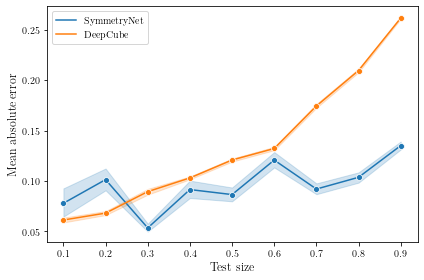

<Figure size 432x288 with 0 Axes>

In [75]:
sns.lineplot(data=final_maes_df, markers=True, x="test_size", y="final_test_mean", hue="Model", marker="o")
# plt.title(f'MAE on test set after training with varying test sizes', fontsize=14)
plt.title('')
plt.xlabel('Test size', fontsize=12)
plt.ylabel('Mean absolute error', fontsize=12)
plt.legend(title='')
plt.tight_layout()
plt.savefig(f'imgs/convergence/{DATASET}/test_conv_per_testsize.png', dpi=100)
plt.savefig(f'imgs/convergence/{DATASET}/test_conv_per_testsize.pdf', format='pdf')
plt.show()
plt.cla()
plt.clf()

# Adversarial Experiments

In [76]:
DATASET = 'kociemba'
models = ['SymEqNet_adv', 'ResNet_adv']
TEST_SIZE = '47.0'

In [77]:
dataset_sizes = [10,100,1000,10000,100000]
rnd_seeds = list(range(0, 10))

In [78]:
RESULT_FOLDERS = {
    DATASET_SIZE: {
        model: f'results/{DATASET}{DATASET_SIZE}/{model}' for model in models
    } for DATASET_SIZE in dataset_sizes
}

In [79]:
last_train_losses_dict, last_test_losses_dict, mean_train_losses_dict, mean_test_losses_dict, results_train_dict, results_test_dict = [
    {model: {datasetsize: [] for datasetsize in dataset_sizes} for model in models} for i in range(6)
]

for datasetsize in dataset_sizes:
    for model in models:
        for i, rndseed in enumerate(rnd_seeds):
#             print(RESULT_FOLDERS[datasetsize][model] + f'/last_train_losses_rs{rndseed}_ts{TEST_SIZE}.npy')
            if os.path.isfile(RESULT_FOLDERS[datasetsize][model] + f'/last_train_losses_rs{rndseed}_ts{TEST_SIZE}.npy'):
#                 print('yes')
                last_train_losses = np.load(RESULT_FOLDERS[datasetsize][model] + f'/last_train_losses_rs{rndseed}_ts{TEST_SIZE}.npy')
                last_test_losses = np.load(RESULT_FOLDERS[datasetsize][model] + f'/last_test_losses_rs{rndseed}_ts{TEST_SIZE}.npy')
                mean_train_losses = np.load(RESULT_FOLDERS[datasetsize][model] + f'/mean_train_losses_rs{rndseed}_ts{TEST_SIZE}.npy')
                mean_test_losses = np.load(RESULT_FOLDERS[datasetsize][model] + f'/mean_test_losses_rs{rndseed}_ts{TEST_SIZE}.npy')
                results = np.load(RESULT_FOLDERS[datasetsize][model] + f'/results_rs{rndseed}_ts{TEST_SIZE}.npy')
            else:
#                 print('oh no')
                last_train_losses = []
                last_test_losses = []
                mean_train_losses = np.zeros(1000)
                mean_test_losses = np.zeros(1000)
                results = [0, 0]
            
#             print(results)
            last_train_losses_dict[model][datasetsize].append(last_train_losses)
            last_test_losses_dict[model][datasetsize].append(last_test_losses)
            mean_train_losses_dict[model][datasetsize].append(mean_train_losses)
            mean_test_losses_dict[model][datasetsize].append(mean_test_losses)
            results_train_dict[model][datasetsize].append(results[0])
            results_test_dict[model][datasetsize].append(results[1])

In [80]:
models_maes_stds = []
for model in models:
    maes_stds= []
    print(f'MODEL {model}')
    for key in results_test_dict[model]:
        mean = np.mean(results_test_dict[model][key])
        std = np.std(results_test_dict[model][key])
        print(f'Dataset Size {key}: MAE {mean:.4f} +- {std:.4f}')
        maes_stds.append(f'{mean:.4f} +- {std:.4f}')
    print('')
    models_maes_stds.append(maes_stds)

MODEL SymEqNet_adv
Dataset Size 10: MAE 6.5421 +- 0.8793
Dataset Size 100: MAE 6.0905 +- 0.9017
Dataset Size 1000: MAE 5.0410 +- 0.9732
Dataset Size 10000: MAE 0.4834 +- 0.0342
Dataset Size 100000: MAE 0.4913 +- 0.0208

MODEL ResNet_adv
Dataset Size 10: MAE 12.0195 +- 0.6078
Dataset Size 100: MAE 9.4784 +- 0.5460
Dataset Size 1000: MAE 7.0128 +- 0.6516
Dataset Size 10000: MAE 0.6340 +- 0.0164
Dataset Size 100000: MAE 0.5745 +- 0.0104



In [81]:
model_ls, random_seed_ls, dataset_size_ls, train_loss_ls, test_loss_ls, epochs = [], [], [], [], [], []
# for model in ['SymEqNet', 'ResNet']:
for datasetsize in dataset_sizes:
    for model in models:
        for rs in rnd_seeds:
            for epoch in range(100):
                model_ls.append(model.replace('_adv', ''))
                random_seed_ls.append(rs)
                dataset_size_ls.append(datasetsize)
                train_loss_ls.append(mean_train_losses_dict[model][datasetsize][rs][epoch])
                test_loss_ls.append(mean_test_losses_dict[model][datasetsize][rs][epoch])
                epochs.append(epoch+1)

In [82]:
df = pd.DataFrame({'Model': list(map(lambda x: model_label_dict[x], model_ls)), 'random_seed': random_seed_ls, 'dataset_size': dataset_size_ls, 'train_loss': train_loss_ls, 'test_loss': test_loss_ls, 'epoch': epochs})
print(df[['random_seed', 'train_loss']].groupby('random_seed').last())
df.head()

             train_loss
random_seed            
0              0.154560
1              0.146760
2              0.149089
3              0.147478
4              0.152665
5              0.146397
6              0.143800
7              0.141465
8              0.167298
9              0.142029


,Model,random_seed,dataset_size,train_loss,test_loss,epoch
0,SymmetryNet,0,10,22.107504,22.107504,1
1,SymmetryNet,0,10,17.317169,20.775930,2
2,SymmetryNet,0,10,16.972231,19.987867,3
3,SymmetryNet,0,10,16.577653,19.410268,4
4,SymmetryNet,0,10,16.280254,18.789603,5


In [83]:
os.makedirs(f'imgs/convergence/{DATASET}_adv', exist_ok=True)
os.makedirs(f'imgs/convergence/{DATASET}_adv/train', exist_ok=True)
os.makedirs(f'imgs/convergence/{DATASET}_adv/test', exist_ok=True)
os.makedirs(f'imgs/convergence/{DATASET}_adv/train_test_combined', exist_ok=True)

,Model,random_seed,dataset_size,train_loss,test_loss,epoch
0,SymmetryNet,0,10,22.107504,22.107504,1
1,SymmetryNet,0,10,17.317169,20.775930,2
2,SymmetryNet,0,10,16.972231,19.987867,3
3,SymmetryNet,0,10,16.577653,19.410268,4
4,SymmetryNet,0,10,16.280254,18.789603,5


2000


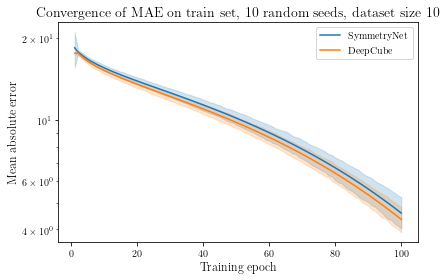

,Model,random_seed,dataset_size,train_loss,test_loss,epoch
2000,SymmetryNet,0,100,22.308989,22.308989,1
2001,SymmetryNet,0,100,17.577181,20.543115,2
2002,SymmetryNet,0,100,17.131446,19.716979,3
2003,SymmetryNet,0,100,16.822487,18.834090,4
2004,SymmetryNet,0,100,16.562991,18.148959,5


2000


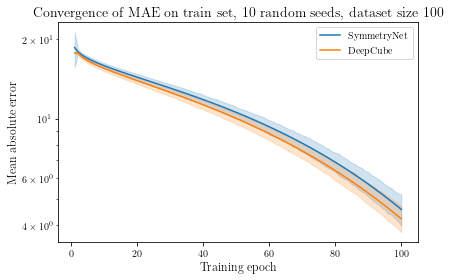

,Model,random_seed,dataset_size,train_loss,test_loss,epoch
4000,SymmetryNet,0,1000,22.337192,22.337192,1
4001,SymmetryNet,0,1000,17.632711,20.718463,2
4002,SymmetryNet,0,1000,17.172959,19.745582,3
4003,SymmetryNet,0,1000,16.839006,18.332270,4
4004,SymmetryNet,0,1000,16.562318,17.306650,5


2000


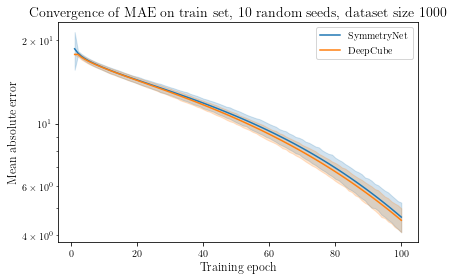

,Model,random_seed,dataset_size,train_loss,test_loss,epoch
6000,SymmetryNet,0,10000,22.328524,22.328524,1
6001,SymmetryNet,0,10000,16.339242,7.929074,2
6002,SymmetryNet,0,10000,14.500868,10.190924,3
6003,SymmetryNet,0,10000,13.095978,11.494365,4
6004,SymmetryNet,0,10000,11.785177,9.985892,5


2000


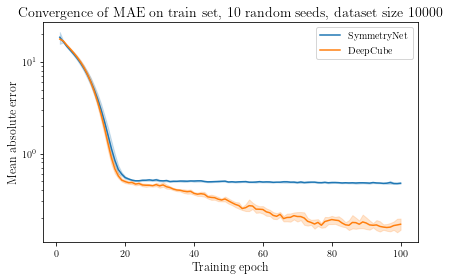

,Model,random_seed,dataset_size,train_loss,test_loss,epoch
8000,SymmetryNet,0,100000,22.333295,22.333295,1
8001,SymmetryNet,0,100000,10.207150,3.934638,2
8002,SymmetryNet,0,100000,1.341072,0.533363,3
8003,SymmetryNet,0,100000,0.510108,0.525208,4
8004,SymmetryNet,0,100000,0.499501,0.524090,5


2000


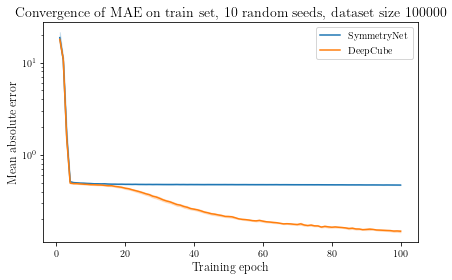

<Figure size 432x288 with 0 Axes>

In [84]:
for dataset_size in dataset_sizes:
    df_dataset_size = df[(df['dataset_size'] == dataset_size)] # & (df['epoch'] % 10 == 0)]
    display(df_dataset_size.head())
    print(len(df_dataset_size.index))
    sns.lineplot(data=df_dataset_size, x="epoch", y="train_loss", hue="Model")
    plt.title('')
    plt.title(f'Convergence of MAE on train set, 10 random seeds, dataset size {dataset_size}', fontsize=14)
    plt.yscale('log')
    plt.xlabel('Training epoch', fontsize=12)
    plt.ylabel('Mean absolute error', fontsize=12)
    plt.legend(title='')
    plt.tight_layout()
    plt.savefig(f'imgs/convergence/{DATASET}_adv/train/train_conv_datasetsize_{dataset_size}.png', dpi=100)
    plt.savefig(f'imgs/convergence/{DATASET}_adv/train/train_conv_datasetsize_{dataset_size}.pdf', format='pdf')
    plt.legend(title='')
    plt.show()
    plt.cla()
    plt.clf()

,Model,random_seed,dataset_size,train_loss,test_loss,epoch
0,SymmetryNet,0,10,22.107504,22.107504,1
1,SymmetryNet,0,10,17.317169,20.775930,2
2,SymmetryNet,0,10,16.972231,19.987867,3
3,SymmetryNet,0,10,16.577653,19.410268,4
4,SymmetryNet,0,10,16.280254,18.789603,5


2000


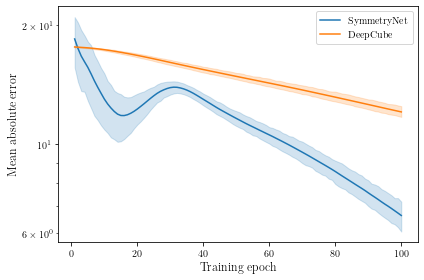

,Model,random_seed,dataset_size,train_loss,test_loss,epoch
2000,SymmetryNet,0,100,22.308989,22.308989,1
2001,SymmetryNet,0,100,17.577181,20.543115,2
2002,SymmetryNet,0,100,17.131446,19.716979,3
2003,SymmetryNet,0,100,16.822487,18.834090,4
2004,SymmetryNet,0,100,16.562991,18.148959,5


2000


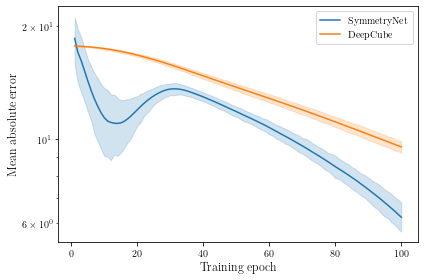

,Model,random_seed,dataset_size,train_loss,test_loss,epoch
4000,SymmetryNet,0,1000,22.337192,22.337192,1
4001,SymmetryNet,0,1000,17.632711,20.718463,2
4002,SymmetryNet,0,1000,17.172959,19.745582,3
4003,SymmetryNet,0,1000,16.839006,18.332270,4
4004,SymmetryNet,0,1000,16.562318,17.306650,5


2000


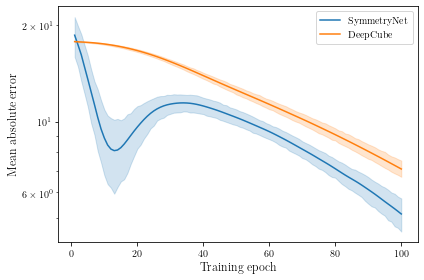

,Model,random_seed,dataset_size,train_loss,test_loss,epoch
6000,SymmetryNet,0,10000,22.328524,22.328524,1
6001,SymmetryNet,0,10000,16.339242,7.929074,2
6002,SymmetryNet,0,10000,14.500868,10.190924,3
6003,SymmetryNet,0,10000,13.095978,11.494365,4
6004,SymmetryNet,0,10000,11.785177,9.985892,5


2000


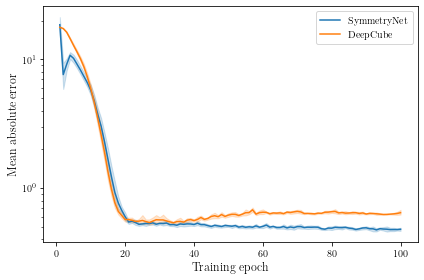

,Model,random_seed,dataset_size,train_loss,test_loss,epoch
8000,SymmetryNet,0,100000,22.333295,22.333295,1
8001,SymmetryNet,0,100000,10.207150,3.934638,2
8002,SymmetryNet,0,100000,1.341072,0.533363,3
8003,SymmetryNet,0,100000,0.510108,0.525208,4
8004,SymmetryNet,0,100000,0.499501,0.524090,5


2000


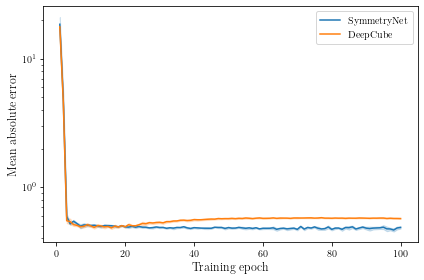

<Figure size 432x288 with 0 Axes>

In [85]:
for dataset_size in dataset_sizes:
    df_dataset_size = df[(df['dataset_size'] == dataset_size)] # & (df['epoch'] % 10 == 0)]
    display(df_dataset_size.head())
    print(len(df_dataset_size.index))
    sns.lineplot(data=df_dataset_size, x="epoch", y="test_loss", hue="Model")
#     plt.title(f'Convergence of MAE on test set, 10 random seeds, dataset size {dataset_size}', fontsize=14)
    plt.title('')
    plt.yscale('log')
    plt.xlabel('Training epoch', fontsize=12)
    plt.ylabel('Mean absolute error', fontsize=12)
    plt.legend(title='')
    plt.tight_layout()
    plt.savefig(f'imgs/convergence/{DATASET}_adv/test/train_conv_datasetsize_{dataset_size}.png', dpi=100)
    plt.savefig(f'imgs/convergence/{DATASET}_adv/test/train_conv_datasetsize_{dataset_size}.pdf', format='pdf')
    plt.show()
    plt.cla()
    plt.clf()

Model           DeepCube
random_seed            9
dataset_size          10
train_loss       4.60659
test_loss         12.168
epoch                100
Name: 1999, dtype: object


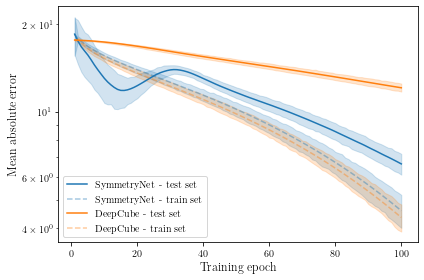

Model           DeepCube
random_seed            9
dataset_size         100
train_loss       4.46512
test_loss        9.73517
epoch                100
Name: 3999, dtype: object


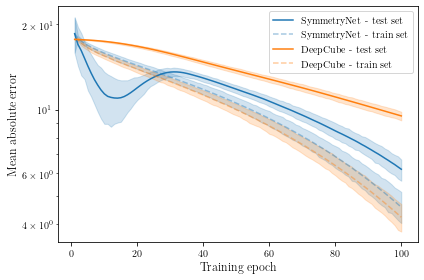

Model           DeepCube
random_seed            9
dataset_size        1000
train_loss       4.72946
test_loss        7.09401
epoch                100
Name: 5999, dtype: object


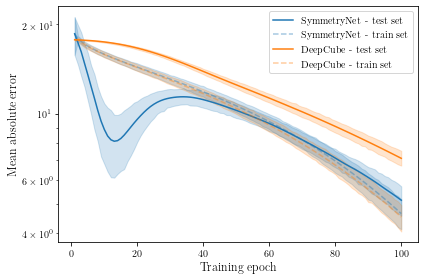

Model           DeepCube
random_seed            9
dataset_size       10000
train_loss      0.151443
test_loss       0.623085
epoch                100
Name: 7999, dtype: object


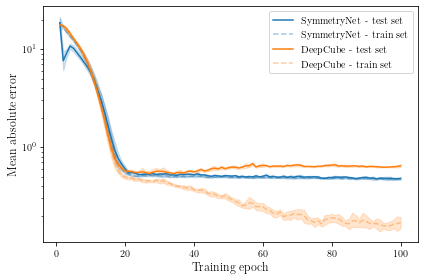

Model           DeepCube
random_seed            9
dataset_size      100000
train_loss      0.142029
test_loss       0.576409
epoch                100
Name: 9999, dtype: object


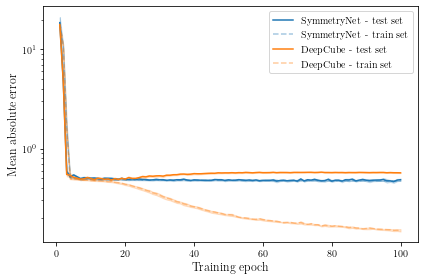

<Figure size 432x288 with 0 Axes>

In [86]:
colors = sns.color_palette()[:len(models)]
for dataset_size in dataset_sizes:
    df_dataset_size = df[(df['dataset_size'] == dataset_size)] # & (df['epoch'] % 10 == 0)]
    print(df_dataset_size.iloc[-1])
    for q, model in enumerate(models):
        model_r = model.replace('_adv', '')
        sns.lineplot(data=df_dataset_size[df_dataset_size['Model'] == model_label_dict[model_r]], x="epoch", y="test_loss", 
                     label=f"{model_label_dict[model_r]} - test set", color=colors[q])
        sns.lineplot(data=df_dataset_size[df_dataset_size['Model'] == model_label_dict[model_r]], x="epoch", y="train_loss", 
                     label=f"{model_label_dict[model_r]} - train set", linestyle='--', color=colors[q], alpha=0.4)
#     plt.title(f'Convergence of MAE, 10 random seeds, dataset size {dataset_size}', fontsize=14)
    plt.title('')
    plt.yscale('log')
    plt.xlabel('Training epoch', fontsize=12)
    plt.ylabel('Mean absolute error', fontsize=12)
    plt.legend(title='')
    plt.tight_layout()
    plt.savefig(f'imgs/convergence/{DATASET}_adv/train_test_combined/train_test_conv_datasetsize_{dataset_size}.png', dpi=100)
    plt.savefig(f'imgs/convergence/{DATASET}_adv/train_test_combined/train_test_conv_datasetsize_{dataset_size}.pdf', format='pdf')
    plt.show()
    plt.cla()
    plt.clf()

In [87]:
model_ls, means, dataset_size_ls = [], [], []

# for model in ['SymEqNet', 'ResNet']:
for datasetsize in dataset_sizes:
    for model in models:
        for rs in rnd_seeds:
            mean = results_test_dict[model][datasetsize]
            model_ls += [model_label_dict[model.replace('_adv', '')]] * len(mean)
            dataset_size_ls += [datasetsize] * len(mean)
            means += mean
final_maes_df = pd.DataFrame({'final_test_mean': means, 'Model': model_ls, 'dataset_size': dataset_size_ls})

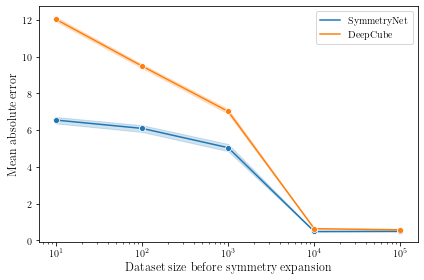

<Figure size 432x288 with 0 Axes>

In [88]:
sns.lineplot(data=final_maes_df, markers=True, x="dataset_size", y="final_test_mean", hue="Model", marker="o")
# plt.title(f'MAE on test set after training with varying dataset sizes', fontsize=14)
plt.title('')
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Dataset size before symmetry expansion', fontsize=12)
plt.ylabel('Mean absolute error', fontsize=12)
plt.legend(title='')
plt.tight_layout()
plt.savefig(f'imgs/convergence/{DATASET}_adv/test_conv_per_testsize.png', dpi=100)
plt.savefig(f'imgs/convergence/{DATASET}_adv/test_conv_per_testsize.pdf', format='pdf')
plt.show()
plt.cla()
plt.clf()

# Compressions

In [146]:
import ast
df6m = pd.read_csv(f'data/processed/6_moves_dataset_single.csv', index_col=0, converters={'colors':ast.literal_eval, 'generator':ast.literal_eval})

In [349]:
for i in range(1,7):
    filtered_df6m = df6m[df6m['distance'] == i]
    nr_classes = len(filtered_df6m['class_id'].unique())
    avg_compr = len(filtered_df6m) / nr_classes
    print(f'DISTANCE {i}')
    print(f'  nr of states: {len(filtered_df6m)}')
    print(f'  nr of classes: {nr_classes}')
    print(f'  average compression ratio: {avg_compr}')

filtered_df6m = df6m[df6m['distance'] != 6]
nr_classes = len(filtered_df6m['class_id'].unique())
avg_compr = len(filtered_df6m) / nr_classes
print(f'ALL')
print(f'  nr of states: {len(filtered_df6m)}')
print(f'  nr of classes: {nr_classes}')
print(f'  average compression ratio: {avg_compr}')

DISTANCE 1
  nr of states: 12
  nr of classes: 1
  average compression ratio: 12.0
DISTANCE 2
  nr of states: 114
  nr of classes: 5
  average compression ratio: 22.8
DISTANCE 3
  nr of states: 1068
  nr of classes: 25
  average compression ratio: 42.72
DISTANCE 4
  nr of states: 10011
  nr of classes: 219
  average compression ratio: 45.71232876712329
DISTANCE 5
  nr of states: 93840
  nr of classes: 1978
  average compression ratio: 47.44186046511628
DISTANCE 6
  nr of states: 878880
  nr of classes: 18395
  average compression ratio: 47.77820059798859
ALL
  nr of states: 105045
  nr of classes: 2228
  average compression ratio: 47.14766606822262


In [51]:
with open(f'data/temp/volume_hashtosizes_distance6.pkl', 'rb') as f:
    vol_dist_hashtodicts = pickle.load(f)

In [323]:
nonunique_num = []
incorrectly_interchangeable = []

for compressions in vol_dist_hashtodicts:
    nn, ii = 0, 0
    for value_list in compressions.values():
        if len(value_list) > 1:
            nn += len(value_list)
            value_list_sum = sum(value_list)
            for value in value_list:
                ii += value * (value_list_sum - value)
    nonunique_num.append(nn)
    incorrectly_interchangeable.append(ii/2)

print(f'Nr of classes with non-unique hashes:\n{", ".join(map(str, nonunique_num))}\n')
print(f'Nr of incorrectly interchangeable members:\n{", ".join(map(str, incorrectly_interchangeable))}\n')

Nr of classes with non-unique hashes:
0, 2, 0, 30, 1378, 17800

Nr of incorrectly interchangeable members:
0.0, 36.0, 0.0, 41472.0, 3536640.0, 297815184.0



In [61]:
incorrectly_interchangeable = []

for i, compressions1 in enumerate(vol_dist_hashtodicts):
    nn, ii = 0, 0
    for comp_hash, value_list1 in compressions1.items():
        comp1_sum = np.sum(value_list1)
        for j, compressions2 in enumerate(vol_dist_hashtodicts):
            if i == j:
                continue
            if comp_hash in compressions2:
                comp2_sum = np.sum(compressions2[comp_hash])
                ii += comp2_sum * comp1_sum
    incorrectly_interchangeable.append(ii/2)

print(f'Nr of incorrectly interchangeable members:\n{", ".join(map(str, incorrectly_interchangeable))}\n')

Nr of incorrectly interchangeable members:
0.0, 1152.0, 101088.0, 2407356.0, 29859552.0, 31683708.0



In [54]:
incorrectly_interchangeable = []

for i, compressions1 in enumerate(vol_dist_hashtodicts[:-1]):
    nn, ii = 0, 0
    for comp_hash, value_list1 in compressions1.items():
        comp1_sum = np.sum(value_list1)
        for j, compressions2 in enumerate(vol_dist_hashtodicts[:-1]):
            if i == j:
                continue
            if comp_hash in compressions2:
                comp2_sum = np.sum(compressions2[comp_hash])
                ii += comp2_sum * comp1_sum
    incorrectly_interchangeable.append(ii/2)

print(f'Nr of incorrectly interchangeable members:\n{", ".join(map(str, incorrectly_interchangeable))}\n')

Nr of incorrectly interchangeable members:
0.0, 1152.0, 16128.0, 331776.0, 336384.0



In [348]:
for i, compressions in enumerate(vol_dist_hashtodicts):
    sizes = [np.sum(xs) for xs in compressions.values()]
#     print(i+1)
    print(np.mean(sizes))
print(np.mean([np.sum(xs) for compressions in vol_dist_hashtodicts[:-1] for xs in compressions.values()]))

12.0
28.5
42.72
49.31527093596059
85.6986301369863
356.39902676399026
79.10015060240964


In [303]:
vol_dist_hashtodicts_agg = defaultdict(list)
for compressions in vol_dist_hashtodicts[:-1]:
    for key, values in compressions.items():
        vol_dist_hashtodicts_agg[key] += values
nn, ii = 0, 0
for value_list in vol_dist_hashtodicts_agg.values():
    if len(value_list) > 1:
        nn += len(value_list)
        value_list_sum = sum(value_list)
        for value in value_list:
            ii += value * (value_list_sum - value)
print(f'Nr of classes with non-unique hashes: {nn}')
print(f'Nr of incorrectly interchangeable members: {ii/2}')

Nr of classes with non-unique hashes: 1585
Nr of incorrectly interchangeable members: 4263588.0


In [333]:
with open(f'data/temp/distance_hashtosizes_distance6.pkl', 'rb') as f:
    dist_dist_hashtodicts = pickle.load(f)

In [334]:
nonunique_num = []
incorrectly_interchangeable = []

for compressions in dist_dist_hashtodicts:
    nn, ii = 0, 0
    for value_list in compressions.values():
        if len(value_list) > 1:
            nn += len(value_list)
            value_list_sum = sum(value_list)
            print(value_list)
            print(value_list_sum)
            for value in value_list:
                ii += value * (value_list_sum - value)
    nonunique_num.append(nn)
    incorrectly_interchangeable.append(ii/2)
            
print(f'Nr of classes with non-unique hashes:\n{", ".join(map(str, nonunique_num))}\n')
print(f'Nr of incorrectly interchangeable members:\n{", ".join(map(str, incorrectly_interchangeable))}\n')

[12, 12]
24
Nr of classes with non-unique hashes:
0, 0, 0, 0, 0, 2

Nr of incorrectly interchangeable members:
0.0, 0.0, 0.0, 0.0, 0.0, 144.0



In [350]:
for i, compressions in enumerate(dist_dist_hashtodicts):
    sizes = [np.sum(xs) for xs in compressions.values()]
#     print(i+1)
    print(np.mean(sizes))
print(np.mean([np.sum(xs) for compressions in dist_dist_hashtodicts[:-1] for xs in compressions.values()]))

12.0
22.8
42.72
45.71232876712329
47.44186046511628
47.7807980863325
47.14766606822262


In [236]:
dist_dist_hashtodicts_agg = defaultdict(list)
for compressions in dist_dist_hashtodicts:
    for key, values in compressions.items():
        dist_dist_hashtodicts_agg[key] += values
nn, ii = 0, 0
for value_list in dist_dist_hashtodicts_agg.values():
    if len(value_list) > 1:
        nn += len(value_list)
        value_list_sum = sum(value_list)
        for value in value_list:
            ii += value * (value_list_sum - value)
print(f'Nr of classes with non-unique hashes: {nn}')
print(f'Nr of incorrectly interchangeable members: {ii/2}')

Nr of classes with non-unique hashes: 2
Nr of incorrectly interchangeable members: 144.0


In [56]:
with open(f'data/temp/volume_hashtosizes_kociemba.pkl', 'rb') as f:
    vol_koc_hashtodicts = pickle.load(f)

In [57]:
nonunique_num = []
incorrectly_interchangeable = []

for compressions in vol_koc_hashtodicts:
    nn, ii = 0, 0
    for value_list in compressions.values():
        if len(value_list) > 1:
            nn += len(value_list)
            value_list_sum = sum(value_list)
            for value in value_list:
                ii += value * (value_list_sum - value)
    nonunique_num.append(nn)
    incorrectly_interchangeable.append(ii/2)
            
print(f'Nr of classes with non-unique hashes:\n{", ".join(map(str, nonunique_num))}\n')
print(f'Nr of incorrectly interchangeable members:\n{", ".join(map(str, incorrectly_interchangeable))}\n')

Nr of classes with non-unique hashes:
6, 22, 2292, 26284, 66728, 2901

Nr of incorrectly interchangeable members:
6912.0, 25344.0, 9377280.0, 939034368.0, 6107452416.0, 14768640.0



In [60]:
incorrectly_interchangeable = []

for i, compressions1 in enumerate(vol_koc_hashtodicts):
    nn, ii = 0, 0
    for comp_hash, value_list1 in compressions1.items():
        comp1_sum = sum(value_list1)
        for j, compressions2 in enumerate(vol_koc_hashtodicts):
            if i == j:
                continue
            if comp_hash in compressions2:
                comp2_sum = sum(compressions2[comp_hash])
                ii += comp2_sum * comp1_sum
    incorrectly_interchangeable.append(ii/2)

print(f'Nr of incorrectly interchangeable members:\n{", ".join(map(str, incorrectly_interchangeable))}\n')

Nr of incorrectly interchangeable members:
2484864.0, 24810624.0, 345217536.0, 2614694400.0, 2950297344.0, 426272256.0



In [346]:
for i, compressions in enumerate(vol_koc_hashtodicts):
    sizes = [np.sum(xs) for xs in compressions.values()]
#     print(i+1)
    print(np.mean(sizes))
print(np.mean([np.sum(xs) for compressions in vol_koc_hashtodicts for xs in compressions.values()]))

57.6
50.83870967741935
123.65019011406844
649.5707762557078
1427.0057598582189
142.57553956834533
728.0448961019263


In [242]:
vol_koc_hashtodicts_agg = defaultdict(list)
for compressions in vol_koc_hashtodicts:
    for key, values in compressions.items():
        vol_koc_hashtodicts_agg[key] += values
nn, ii = 0, 0
for value_list in vol_koc_hashtodicts_agg.values():
    if len(value_list) > 1:
        nn += len(value_list)
        value_list_sum = sum(value_list)
        for value in value_list:
            ii += value * (value_list_sum - value)
print(f'Nr of classes with non-unique hashes: {nn}')
print(f'Nr of incorrectly interchangeable members: {ii/2}')

Nr of classes with non-unique hashes: 99640
Nr of incorrectly interchangeable members: 13434441984.0


In [341]:
with open(f'data/temp/distance_hashtosizes_kociemba.pkl', 'rb') as f:
    dist_koc_hashtodicts = pickle.load(f)

In [342]:
nonunique_num = []
incorrectly_interchangeable = []

for compressions in dist_koc_hashtodicts:
    nn, ii = 0, 0
    for value_list in compressions.values():
        if len(value_list) > 1:
            nn += len(value_list)
            value_list_sum = sum(value_list)
            for value in value_list:
                ii += value * (value_list_sum - value)
    nonunique_num.append(nn)
    incorrectly_interchangeable.append(ii/2)
            
print(f'Nr of classes with non-unique hashes:\n{", ".join(map(str, nonunique_num))}\n')
print(f'Nr of incorrectly interchangeable members:\n{", ".join(map(str, incorrectly_interchangeable))}\n')

Nr of classes with non-unique hashes:
0, 0, 0, 0, 0, 0

Nr of incorrectly interchangeable members:
0.0, 0.0, 0.0, 0.0, 0.0, 0.0



In [343]:
for i, compressions in enumerate(dist_koc_hashtodicts):
    sizes = [np.sum(xs) for xs in compressions.values()]
#     print(i+1)
    print(np.mean(sizes))
print(np.mean([np.sum(xs) for compressions in dist_koc_hashtodicts for xs in compressions.values()]))

48.0
48.0
48.0
48.0
48.0
48.0
48.0


In [239]:
dist_koc_hashtodicts_agg = defaultdict(list)
for compressions in dist_koc_hashtodicts:
    for key, values in compressions.items():
        dist_koc_hashtodicts_agg[key] += values
nn, ii = 0, 0
for value_list in dist_koc_hashtodicts_agg.values():
    if len(value_list) > 1:
        nn += len(value_list)
        value_list_sum = sum(value_list)
        for value in value_list:
            ii += value * (value_list_sum - value)
print(f'Nr of classes with non-unique hashes: {nn}')
print(f'Nr of incorrectly interchangeable members: {ii/2}')

Nr of classes with non-unique hashes: 0
Nr of incorrectly interchangeable members: 0.0


In [187]:
len(dist_koc_hashtodicts_agg.keys())

100000

In [218]:
from generate.symmetry_config import pos_list
from scipy.spatial import ConvexHull, distance_matrix

def indices_to_position(indices):
    pos_array = np.array(pos_list)
    return pos_array[np.array(indices)]

def create_dicts_from_data(df: pd.DataFrame, distance: int, input_handling_func):
    """
    Use dataset of cube states and their generators to produce a dictionary of compression classes
    based on the processed data (e.g., volumes, distances, angles, etc.).
    """
    distance_x_dict = defaultdict(list)
    hash_to_sizes = defaultdict(list)
    df_x = df[df['distance'] == distance]
    for class_id in sorted(df_x['class_id'].unique()):
        distance_x = df_x[df_x['class_id'] == class_id]['colors']
        distance_x_gens = df_x[df_x['class_id'] == class_id]['generator']
        distance_x_cls = df_x[df_x['class_id'] == class_id]['class_id']
    
        processed_data = None
        for i, (cube, cube_gen, cube_cls) in enumerate(tqdm(list(zip(distance_x, distance_x_gens, distance_x_cls)))):
            processed_data = input_handling_func(cube, verbose=False, aggregate=True, for_hashing=True)
            if isinstance(processed_data[0], np.ndarray):
                processed_data = [hash(sub_array.tostring()) for sub_array in processed_data]
            processed_data = sorted(processed_data)
            distance_x_dict[tuple(processed_data)].append((i, cube_gen, cube_cls))
        hash_to_sizes[tuple(processed_data)].append(len(distance_x.index))
    return distance_x_dict, hash_to_sizes

def calc_distances_pairwise_sum(vertices):
    vertices = indices_to_position(vertices)
    distances = distance_matrix(vertices, vertices)
    distances = np.sort(distances.sum(axis=1))
    distances = np.rint(distances * 10e4).astype(int)
    return distances

counterDist = 0

def calc_all_distances(colors, verbose=True, aggregate=False, for_hashing=False):
    if verbose:
        global counterDist
        counterDist += 1
        if (counterDist + 1) % 1000 == 0:
            print(counterDist + 1)
    distances_ls = []
    indices = np.arange(54)
    colors = np.array(colors)
    for color in range(6):
        filtered_indices = indices[colors == color]
        distances = calc_distances_pairwise_sum(tuple(filtered_indices))
        distances_ls.append(distances)
    distances_ls = np.array(distances_ls)
    if aggregate:
        distances_ls = np.sum(distances_ls, axis=0, dtype=int)
    return distances_ls

In [220]:
create_dicts_from_data(df6m, 2, calc_all_distances)

100%|███████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 711.81it/s]


(defaultdict(list,
             {(8180950,
               9227028,
               9608448,
               9608448,
               10108352,
               10591196,
               12096712,
               12819304,
               12819304): [(0, [["U'", "U'"]], 1),
               (1, [["R'", "R'"]], 1),
               (2, [["D'", "D'"]], 1),
               (3, [["L'", "L'"]], 1),
               (4, [["F'", "F'"]], 1),
               (5, [["B'", "B'"]], 1)],
              (8569966,
               9791808,
               9791808,
               10581912,
               10581912,
               11097800,
               11097800,
               12529104,
               12529104): [(0, [["U'", "D'"]], 2),
               (1, [["R'", "L'"]], 2),
               (2, [["F'", "B'"]], 2),
               (3, [['U', 'D']], 2),
               (4, [['R', 'L']], 2),
               (5, [['F', 'B']], 2)],
              (7798718,
               8768264,
               8768264,
               8819584,
    